# 2019 POLEVAL TASK 6.1
**Data preprocessing**


---





http://2019.poleval.pl/index.php/tasks/task6


## To install and download

In [3]:
!pip install argparse -q    #Argparse 3.2
!pip install xtract -q    #Xtract 0.1 a3
!pip install wget -q    #Wget 3.2
!pip install -U -q PyDrive
!python -m pip install spacy==2.3.2 -q
# always restart session after spacy installation
!python -m spacy download pl_core_news_md  -q
!python -m spacy download pl_core_news_lg -q #

     |████████████████████████████████| 9.9 MB 5.1 MB/s 
     |████████████████████████████████| 2.1 MB 59.1 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_md')
     |████████████████████████████████| 604.2 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pl_core_news_lg')


In [1]:
# install and download 
from IPython.display import clear_output
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import re
import numpy as np
import string
import time

# wizualizacja
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
# nltk - do preprocessingu
import nltk
from nltk.stem import WordNetLemmatizer
import spacy

## Download train and test data from Google Drive


In [2]:
#Authenticate
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
#train data
path1 = '/content/drive/MyDrive/training_set_clean_only_text.txt' 
path2 = '/content/drive/MyDrive/training_set_clean_only_tags.txt'  
df1 = pd.read_csv(path1, delimiter = "\t", header = None)
df1.columns = ['tweets_txt']
df2 = pd.read_csv(path2, delimiter = "\t", header = None)
df2.columns = ['tag']
train_data = pd.concat([df1.reset_index(drop=True), df2], axis=1,)
train_data.head(10)

,tweets_txt,tag
0,Dla mnie faworytem do tytułu będzie Cracovia. ...,0
1,@anonymized_account @anonymized_account Brawo ...,0
2,"@anonymized_account @anonymized_account Super,...",0
3,@anonymized_account @anonymized_account Musi. ...,0
4,"Odrzut natychmiastowy, kwaśna mina, mam problem",0
5,"Jaki on był fajny xdd pamiętam, że spóźniłam s...",0
6,@anonymized_account No nie ma u nas szczęścia 😉,0
7,@anonymized_account Dawno kogoś tak wrednego n...,0
8,@anonymized_account @anonymized_account Zaległ...,0
9,@anonymized_account @anonymized_account @anony...,1


In [4]:
#test data
path1 = '/content/drive/MyDrive/test_set_clean_only_text.txt' 
path2 = '/content/drive/MyDrive/test_set_clean_only_tags.txt'  
df1 = pd.read_csv(path1, delimiter = "\t", header = None)
df1.columns = ['tweets_txt']
df2 = pd.read_csv(path2, delimiter = "\t", header = None)
df2.columns = ['tag']
test_data = pd.concat([df1.reset_index(drop=True), df2], axis=1,)
test_data.head(10)

,tweets_txt,tag
0,"@anonymized_account Spoko, jak im Duda z Moraw...",0
1,@anonymized_account @anonymized_account Ale on...,0
2,@anonymized_account No czy Prezes nie miał rac...,0
3,@anonymized_account @anonymized_account Przeci...,0
4,@anonymized_account @anonymized_account Owszem...,0
5,@anonymized_account @anonymized_account skąd w...,0
6,"Z tego, co widzę, to kibice Widzewa mają szczę...",0
7,@anonymized_account @anonymized_account @anony...,0
8,Przypomnijcie mi ze muszę jeszcze suszarkę spa...,0
9,"Czy Adam już nie żyje? Jeśli tak, to jak rozwi...",0


In [5]:
#map tags values 
di = {0:'Neutral', 1:'Harmful'}
test_data["tag_val"] = test_data["tag"].map(di)
train_data["tag_val"] = train_data["tag"].map(di)

## Data exploration

In [6]:
# join train and test data together
df = train_data.append(test_data, ignore_index=True)

In [7]:
n = len(df)
print(f'number of train_comments: {len(train_data)} ({round(len(train_data)/n *100, 2)}%).')
print(f'number of test_comments: {len(test_data)} ({round(len(test_data)/n *100, 2)}%).')
print(f'total: {n}')

number of train_comments: 10041 (90.94%).
number of test_comments: 1000 (9.06%).
total: 11041


In [8]:
# dystrybucja 
df.groupby('tag_val').nunique()

,tweets_txt,tag
tag_val,,
Harmful,984,1
Neutral,10043,1


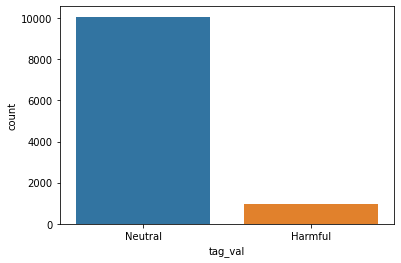

In [9]:
sns.countplot(x='tag_val', data=df)

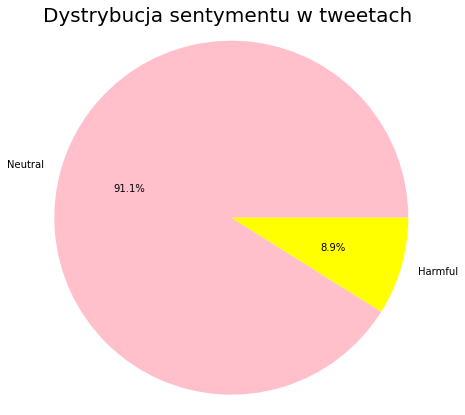

,index,tag_val
0,Neutral,10056
1,Harmful,985


In [10]:
fig = plt.gcf()
fig.set_size_inches(7,7)
colors = ["pink","yellow"]
df_pie=df["tag_val"].value_counts().reset_index()
plt.pie(df_pie["tag_val"], labels = df_pie["index"], radius=2, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
plt.title("Dystrybucja sentymentu w tweetach ", fontsize=20)
plt.show()
df_pie

In [11]:
from collections import Counter
def get_most_common(txt, top=20):
  words = (txt).split()
  print(f'Found {len(words)} words.')
  most_common = Counter(words).most_common(top)
  labels = []
  values = []
  for label, val in most_common:
    labels.append(label)
    values.append(val)
  return values, labels

def plot_most_common(txt_comments, top=20, title=''):
  values, labels = get_most_common(txt_comments, top)
  x = range(len(values))

  plt.figure(figsize=(15, 5))
  plt.bar(x, values)
  plt.xticks(x, labels, rotation=90)
  plt.title(title)
  plt.show()

Found 71977 words.


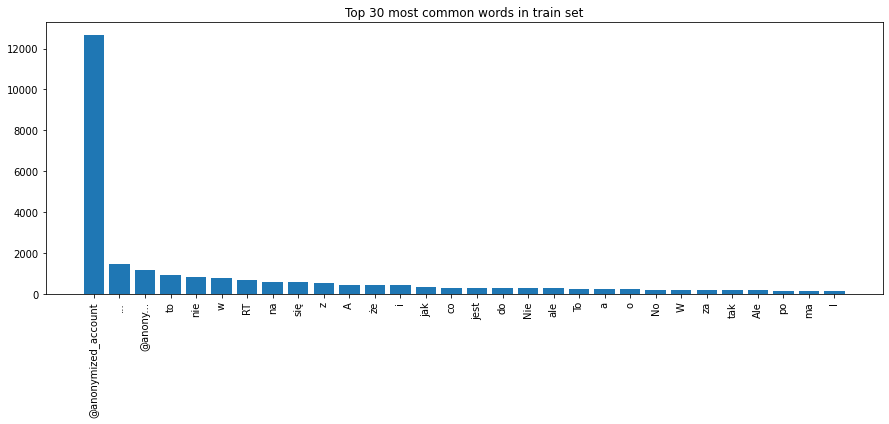

In [12]:
tweets = df['tweets_txt'].to_string()
plot_most_common(tweets, top=30, title='Top 30 most common words in train set')

## Data preprocessing


### Drop duplicate values and normalize


In [13]:
# drop duplicate values
df['tweets_txt'].drop_duplicates(keep="first", inplace=True)

### Normalization make all strings lowercase
df['tweets_txt']= df['tweets_txt'].str.lower() 
df.head()

,tweets_txt,tag,tag_val
0,dla mnie faworytem do tytułu będzie cracovia. ...,0,Neutral
1,@anonymized_account @anonymized_account brawo ...,0,Neutral
2,"@anonymized_account @anonymized_account super,...",0,Neutral
3,@anonymized_account @anonymized_account musi. ...,0,Neutral
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0,Neutral


### Stopwords


In [14]:
import spacy
nlp = spacy.load('pl_core_news_md')

In [15]:
lemma = WordNetLemmatizer()
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [16]:
stopwordlist = nlp.Defaults.stop_words
print(stopwordlist)

{'właśnie', 'toteż', 'inny', 'jemu', 'powinna', 'wami', 'ponad', 'tym', 'wasz', 'był', 'już', 'przeciez', 'takze', 'jezeli', 'jakis', 'gdzie', 'ona', 'żeby', 'poniewaz', 'acz', 'dla', 'miał', 'jeden', 'ze', 'może', 'nami', 'sobie', 'nasz', 'będę', 'ta', 'którzy', 'no', 'chce', 'tel', 'na', 'ale', 'dużo', 'dwaj', 'tej', 'nad', 'choć', 'między', 'tych', 'ci', 'ja', 'więcej', 'można', 'znow', 'jakby', 'miedzy', 'sposób', 'wielu', 'ani', 'będzie', 'ktos', 'tobą', 'pomimo', 'dwie', 'sposob', 'bede', 'zadnych', 'mimo', 'ktoś', 'xii', 'temu', 'wszystkim', 'wie', 'jej', 'naszego', 'was', 'bylo', 'też', 'żaden', 'czemu', 'moja', 'poza', 'przede', 'jeżeli', 'dzisiaj', 'dokad', 'gdzies', 'że', 'byli', 'i', 'iż', 'moj', 'jedynie', 'one', 'sie', 'wy', 'vii', 'jeśli', 'kierunku', 'zawsze', 'wiele', 'mna', 'dzis', 'pani', 'został', 'po', 'wszyscy', 'xiii', 'on', 'której', 'przed', 'zadna', 'za', 'beda', 'zaden', 'około', 'jedna', 'owszem', 'wlasnie', 'którym', 'żadne', 'ktore', 'gdzieś', 'trzeba', 'v

In [17]:
def clean_text(text):
  text = text.replace("@anonymized_account", ' ')
  text = text.replace("rt", ' ')
  text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text) # URL 
  text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
  text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
  text = re.sub('[0-9]+', '', text)  # deleting numbers
  text = re.sub(r'(.)1+', r'1', text) # repeating chars
  text = re.sub(r'[^\w\s]','',text) #remove everything except words and space
  text = re.sub(r'_','', text)
  text = re.sub('\t', '', text)
  text = ' '.join( [w for w in text.split() if len(w)>1] )
  text = ' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist])
  text = [lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(text) if x not in stopwordlist]
  return text

In [18]:
df["clean_tokenized"] = df["tweets_txt"].apply(clean_text)
df['cleaned_text'] = df['clean_tokenized'].apply(lambda x:' '.join(x))

df.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text
0,dla mnie faworytem do tytułu będzie cracovia. ...,0,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi
1,@anonymized_account @anonymized_account brawo ...,0,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe
2,"@anonymized_account @anonymized_account super,...",0,Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...
3,@anonymized_account @anonymized_account musi. ...,0,Neutral,"[innej, drogi]",innej drogi
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0,Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem


### Lematization

In [19]:
nlp = spacy.load('pl_core_news_lg')
tweets = df["cleaned_text"].to_string()

In [20]:
df["lemmatized"] = df['cleaned_text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x)]))

In [21]:
df.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text,lemmatized
0,dla mnie faworytem do tytułu będzie cracovia. ...,0,Neutral,"[faworytem, tytułu, cracovia, zobaczymy, typ, ...",faworytem tytułu cracovia zobaczymy typ sprawdzi,faworyt tytuł cracovia zobaczyć typ sprawdzić
1,@anonymized_account @anonymized_account brawo ...,0,Neutral,"[brawo, daria, kibic, dobre, złe]",brawo daria kibic dobre złe,brawo daria kibic dobry zły
2,"@anonymized_account @anonymized_account super,...",0,Neutral,"[super, polski, premier, składa, kwiaty, groba...",super polski premier składa kwiaty grobach kol...,super polski premiera składać kwiat grób kolab...
3,@anonymized_account @anonymized_account musi. ...,0,Neutral,"[innej, drogi]",innej drogi,inny droga
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0,Neutral,"[odrzut, natychmiastowy, kwaśna, mina, problem]",odrzut natychmiastowy kwaśna mina problem,odrzut natychmiastowy kwaśny mina problem


## Cleaned data exploration

In [24]:
def wordcloud_plot(text: str, bg='white'):
  wordcloud = WordCloud(min_font_size=5, #4
                        max_words=150, #200
                        background_color=bg,
                        ).generate(text)
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.plot()

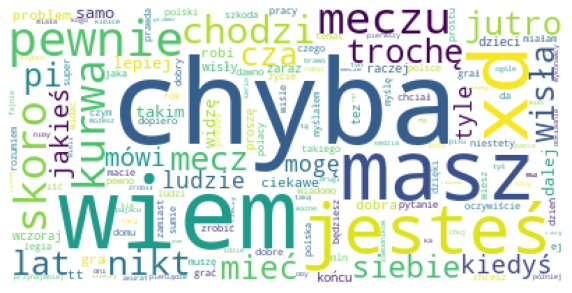

In [23]:
tweets = df['cleaned_text'].to_string()
wordcloud_plot(tweets)

Found 64686 words.


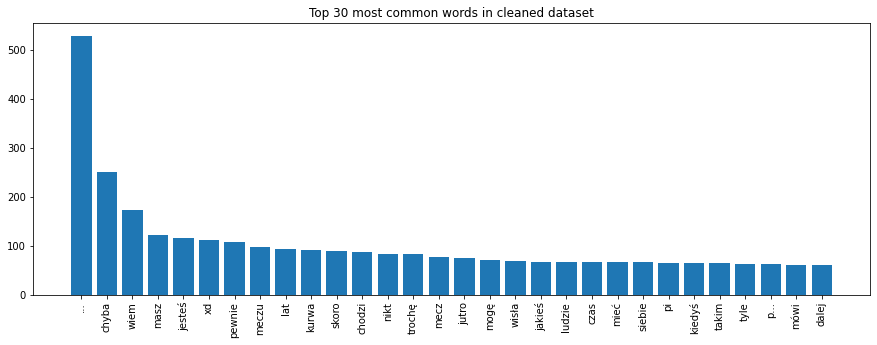

In [25]:
plot_most_common(tweets, top=30, title='Top 30 most common words in cleaned dataset')

## Word distribution in harmful comments

In [36]:
neutral_comments = []
bully_comments = []
for comment, label in zip(df['cleaned_text'], df['tag']):
  if label == 0:
    neutral_comments.append(comment)
  else:
    bully_comments.append(comment)

In [37]:
len(bully_comments)

985

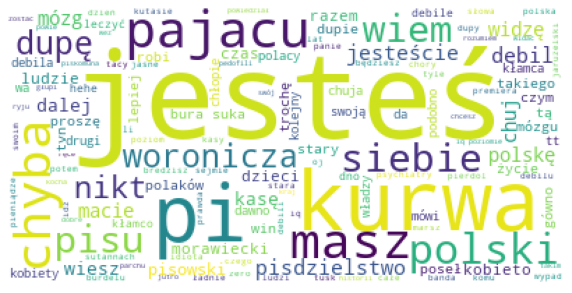

In [38]:
listToStr = ' '.join(map(str, bully_comments))
wordcloud_plot(listToStr)

Found 6205 words.


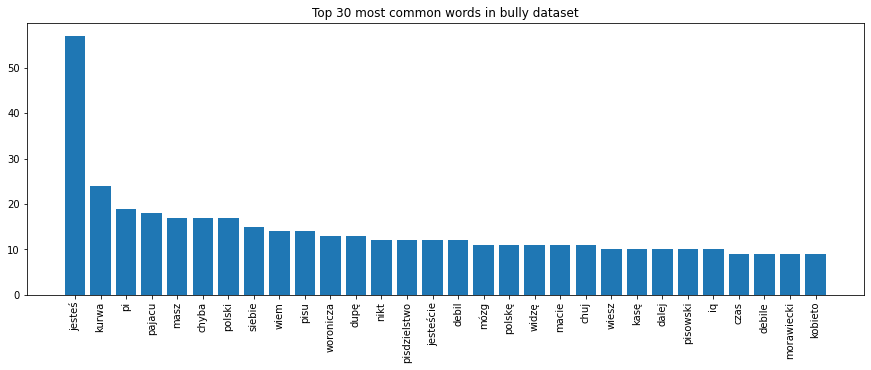

In [40]:
plot_most_common(listToStr, top=30, title='Top 30 most common words in bully dataset')

## Write preprocessed data to Drive

In [58]:
train_data = train_data.astype(str)
train_data['tweets_txt']= train_data['tweets_txt'].str.lower() 

test_data = test_data.astype(str)
test_data['tweets_txt']= test_data['tweets_txt'].str.lower() 

df = df.astype(str)

In [81]:
## left joining df preprocessed data with original train_data
train_data_preprocessed = train_data.merge(df, how='left', on=["tweets_txt", "tag"])
train_data_preprocessed.head()

,tweets_txt,tag,tag_val,clean_tokenized,cleaned_text,lemmatized
0,dla mnie faworytem do tytułu będzie cracovia. ...,0,Neutral,"['faworytem', 'tytułu', 'cracovia', 'zobaczymy...",faworytem tytułu cracovia zobaczymy typ sprawdzi,faworyt tytuł cracovia zobaczyć typ sprawdzić
1,@anonymized_account @anonymized_account brawo ...,0,Neutral,"['brawo', 'daria', 'kibic', 'dobre', 'złe']",brawo daria kibic dobre złe,brawo daria kibic dobry zły
2,"@anonymized_account @anonymized_account super,...",0,Neutral,"['super', 'polski', 'premier', 'składa', 'kwia...",super polski premier składa kwiaty grobach kol...,super polski premiera składać kwiat grób kolab...
3,@anonymized_account @anonymized_account musi. ...,0,Neutral,"['innej', 'drogi']",innej drogi,inny droga
4,"odrzut natychmiastowy, kwaśna mina, mam problem",0,Neutral,"['odrzut', 'natychmiastowy', 'kwaśna', 'mina',...",odrzut natychmiastowy kwaśna mina problem,odrzut natychmiastowy kwaśny mina problem


In [75]:
test_data_preprocessed = test_data.merge(df, how='left', on=["tweets_txt", "tag"])
test_data_preprocessed.head() 

,tweets_txt,tag,tag_val_x,tag_val_y,clean_tokenized,cleaned_text,lemmatized
0,"@anonymized_account spoko, jak im duda z moraw...",0,Neutral,Neutral,"['spoko', 'duda', 'morawieckim', 'zamówią', 'p...",spoko duda morawieckim zamówią pięć piw,spoko duda morawieckim zamówić pięć piwo
1,@anonymized_account @anonymized_account ale on...,0,Neutral,Neutral,"['szans', 'zagrania', 'proba', 'czysta', 'prow...",szans zagrania proba czysta prowizorka,szansa zagranie proba czysty prowizorka
2,@anonymized_account no czy prezes nie miał rac...,0,Neutral,Neutral,"['prezes', 'racji', 'mówiącze', 'zdradzieckie'...",prezes racji mówiącze zdradzieckie mordy racji,prezes racja mówiącze zdradziecki morda racja
3,@anonymized_account @anonymized_account przeci...,0,Neutral,Neutral,['przewrotka'],przewrotka,przewrotka
4,@anonymized_account @anonymized_account owszem...,0,Neutral,Neutral,"['podatki', 'okolicznościach', 'małysza', 'odp...",podatki okolicznościach małysza odpalili teamu...,podatek okoliczność małysza odpalić team orlen


In [79]:
test_data_preprocessed.drop_duplicates(keep="first", inplace=True)
train_data_preprocessed.drop_duplicates(keep="first", inplace=True)

In [80]:
# save preprocessed data 
test_data_preprocessed.to_csv("/content/drive/MyDrive/test_data_preprocessed.csv")
train_data_preprocessed.to_csv("/content/drive/MyDrive/train_data_preprocessed.csv")